In [17]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt

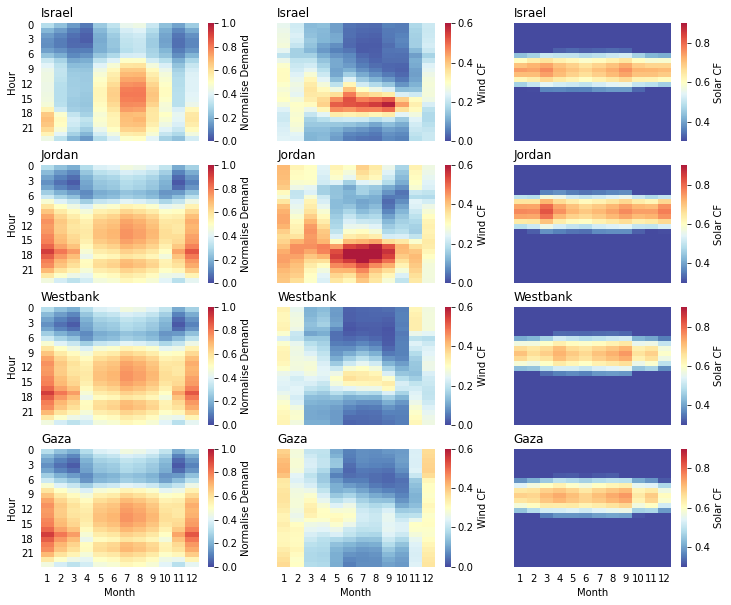

In [19]:
######################################################################
# CAPACITY FACTORS AND ENERGY DEMAND
######################################################################

def normalise_demand(s):
    return s/s.max()

# get energy demand data
basepath = '../data/nextra/nodal_flows/processed_flows_2030_rn.csv'
data = pd.read_csv(basepath)

# normalise
for c in data.columns:
    if 'demand' in c:
        data[c] = (data[c]-data[c].min())/(data[c].max()-data[c].min())

data.columns = [i.replace('energy_','').replace('west_bank','westbank') for i in data.columns]
data = pd.melt(data.drop(['date','year','day'],axis=1), id_vars=['hour','month'],value_name='electricity')
data[['region', 'series']] = data['variable'].str.split('_', 1, expand=True)
data = data.drop(['variable'],axis=1)

f,ax = plt.subplots(nrows=4,ncols=3,figsize=(12,10),sharex=True,sharey=True)
axs = ax.ravel()
count=0

# cbar 
demand_lims = [0,1.0]
wind_lims = [0,0.6]
solar_lims = [0.3,0.9]
titles = ['Normalise Demand','Wind CF','Solar CF']

for region in data.region.unique():
    for tech in data.series.unique():
        d = data[(data.region == region) & (data.series == tech)].pivot_table('electricity','hour','month')
        if count in [0,3,6,9]:
            vmin=demand_lims[0]
            vmax=demand_lims[1]
            title=titles[0]
        elif count in [1,4,7,10]:
            vmin=wind_lims[0]
            vmax=wind_lims[1]
            title=titles[1]
        else:
            vmin=solar_lims[0]
            vmax=solar_lims[1]
            title=titles[2]
        sns.heatmap(d,ax=axs[count],vmin=vmin,vmax=vmax,
                    linewidths=.0,cmap='RdYlBu_r',alpha=0.9,
                    cbar_kws={'label':title})
        axs[count].set_title(region.capitalize(),loc='left')
        axs[count].set_xlabel('')
        axs[count].set_ylabel('')
        axs[count].xaxis.set_ticks_position('none') 
        axs[count].yaxis.set_ticks_position('none') 
        axs[count].tick_params(axis='y', rotation=0)
        count = count + 1

for x in [9,10,11]:
    axs[x].set_xlabel('Month')
for y in [0,3,6,9]:
    axs[y].set_ylabel('Hour')
    
f.savefig('../outputs/figures/forcing_data_heatmap.pdf',bbox_inches='tight')

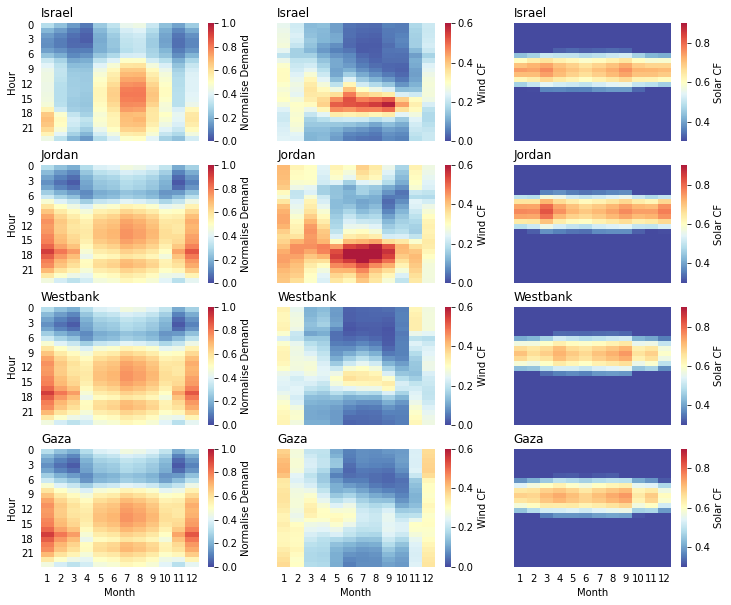

In [ ]:
# # get renewable.ninja data
# basepath = '../data/_raw/renewable_ninja/'

# # load
# data = []
# for f in os.listdir(basepath):
#     if '.csv' in f:
#         d = pd.read_csv(basepath+f,skiprows=3)
#         d['region'] = f.split('.')[0].split('_')[0]
#         d['type'] = f.split('.')[0].split('_')[1]
#         data.append(d)
# data = pd.concat(data,ignore_index=True)

# # format datetime
# data['time'] = pd.to_datetime(data['time'])
# data['month'] = data['time'].dt.month
# data['hour'] = data['time'].dt.hour + 1

# # reindex
# data = data[['hour','month','region','type','electricity']]

In [ ]:
import pandas as pd
import os

##########
# Get renewables ninja data

basepath = '../data/_raw/renewable_ninja/'

# load
data = []
for f in os.listdir(basepath):
    if '.csv' in f:
        d = pd.read_csv(basepath+f,skiprows=3)
        d['region'] = f.split('.')[0].split('_')[0]
        d['type'] = f.split('.')[0].split('_')[1]
        data.append(d)
data = pd.concat(data,ignore_index=True)

# format datetime
data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour 
data['day'] = data['time'].dt.day
data['month'] = data['time'].dt.month

# reindex
data = data[['hour','day','month','region','type','electricity']]

##########
# Get flow data

flowpath = '../data/nextra/nodal_flows/processed_flows_2030.csv'
flows = pd.read_csv(flowpath)

##########
# Amend flows
count=0
for c in flows.columns:
    print('> Processing: ' + c)
    if 'solar' in c or 'wind' in c:
        for i in flows[c].index:
            
            idx = data.loc[(data.hour == flows.loc[i,'hour']) & \
                           (data.day == flows.loc[i,'day']) & \
                           (data.month == flows.loc[i,'month']) ]
                        
            val = idx.loc[ (idx.region.str.contains(c.split('_')[0])) & \
                           (idx.type.str.contains(c.split('_')[-1])), 'electricity'].iloc[0]
            
            
            flows.loc[i,c] = val
            count = count + 1
            
##########
# Save

flows.to_csv('../data/nextra/nodal_flows/processed_flows_2030_rn.csv',index=False)